In [12]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from modechoice.config import MODES
from modechoice.io import load_bundle
from modechoice.pipeline import ModeChoicePipeline
from modechoice.model import NestedLogitHetero
from modechoice.tensors import Standardizer
from modechoice.data import ensure_long_format
from modechoice.features import add_relative_features_long
from modechoice.tensors import build_choice_tensors_hetero

from modechoice.elasticity import own_cost_elasticity, response_curve, plot_substitution_relative

In [3]:
ROOT = Path.cwd()
if not (ROOT / "pyproject.toml").exists():
    ROOT = ROOT.parent

DEVICE = "cpu"
torch.set_default_dtype(torch.float32)

BUNDLE_DIR = ROOT / "artifacts" / "modechoice_bundle"
DATA_PATH  = ROOT / "dataset" / "ModeCanada.csv"

# print("ROOT:", ROOT)
print("BUNDLE_DIR exists:", BUNDLE_DIR.exists())
print("DATA_PATH exists:", DATA_PATH.exists())

BUNDLE_DIR exists: True
DATA_PATH exists: True


In [17]:
pipe = load_bundle(
    BUNDLE_DIR,
    PipelineCls=ModeChoicePipeline,
    ModelCls=NestedLogitHetero,
    ScalerCls=Standardizer,
)

pipe.model.asc, pipe.model.beta  # sanity
print("Loaded feat_names:", len(pipe.scaler.feat_names))
print("Feats:", pipe.scaler.feat_names)
print("Lambdas:", pipe.model.lambdas())

Loaded feat_names: 14
Feats: ['cost', 'ivt', 'ovt', 'freq', 'urban_x_ovt', 'gen_time', 'income_train', 'urban_train', 'income_car', 'urban_car', 'income_bus', 'urban_bus', 'income_air', 'urban_air']
Lambdas: {'air': 0.6149392127990723, 'land': 0.9137387871742249}


In [ ]:
pipe.scaler.mu = np.asarray(pipe.scaler.mu, dtype=np.float32)
pipe.scaler.sd = np.asarray(pipe.scaler.sd, dtype=np.float32)

feat_names = pipe.scaler.feat_names

per_mode_feats = set()
for m in MODES:
    per_mode_feats.add(f"income_{m}")
    per_mode_feats.add(f"urban_{m}")

item_feat_names = [f for f in feat_names if f not in per_mode_feats]

print("Derived item_feat_names:", item_feat_names)
print("Derived D_item:", len(item_feat_names))
print("Total D_model:", len(feat_names))

Derived item_feat_names: ['cost', 'ivt', 'ovt', 'freq', 'urban_x_ovt', 'gen_time']
Derived D_item: 6
Total D_model: 14


In [6]:
df_raw = pd.read_csv(DATA_PATH)
df_long = ensure_long_format(df_raw)

df_long = add_relative_features_long(df_long, w_ovt=2.0, freq_period_minutes=1440.0)

all_t, _ = build_choice_tensors_hetero(df_long, scaler=pipe.scaler, fit_scaler=False, item_feat_names=item_feat_names)

assert all_t["feat_names"] == pipe.scaler.feat_names, "Feature mismatch vs trained scaler!"

print("all_t keys:", all_t.keys())
print("X_item:", all_t["X_item"].shape)
print("X_item_orig:", all_t["X_item_orig"].shape)
print("avail:", all_t["avail"].shape)
print("y:", all_t["y"].shape)

all_t keys: dict_keys(['X_item', 'X_item_orig', 'avail', 'y', 'cases', 'feat_names'])
X_item: torch.Size([4324, 4, 14])
X_item_orig: (4324, 4, 14)
avail: torch.Size([4324, 4])
y: torch.Size([4324])


In [8]:
asc = pipe.model.asc
beta = pipe.model.beta
raw_la = pipe.model.raw_lam_air
raw_ll = pipe.model.raw_lam_land

In [ ]:
changed_mode = "air"  # "train","car","bus","air"
mult_grid = np.linspace(0.7, 1.3, 25)

curve_df = response_curve(
    tensors=all_t,
    scaler=pipe.scaler,
    asc=asc, beta=beta, raw_la=raw_la, raw_ll=raw_ll,
    changed_mode=changed_mode,
    mult_grid=mult_grid,
)

curve_df.head()

,multiplier,mode_changed,demand_train,rel_demand_train,demand_car,rel_demand_car,demand_bus,rel_demand_bus,demand_air,rel_demand_air
0,0.700,air,358.531067,0.574439,1647.903076,0.750195,10.774833,0.623439,2306.791260,1.552408
1,0.725,air,375.319916,0.601338,1692.950806,0.770703,11.283890,0.652893,2244.445557,1.510451
2,0.750,air,392.866974,0.629452,1738.165527,0.791287,11.800375,0.682778,2181.167236,1.467867
3,0.775,air,411.231750,0.658876,1783.504395,0.811927,12.323988,0.713074,2116.940186,1.424644
4,0.800,air,430.481995,0.689718,1828.939209,0.832611,12.854470,0.743768,2051.724365,1.380755


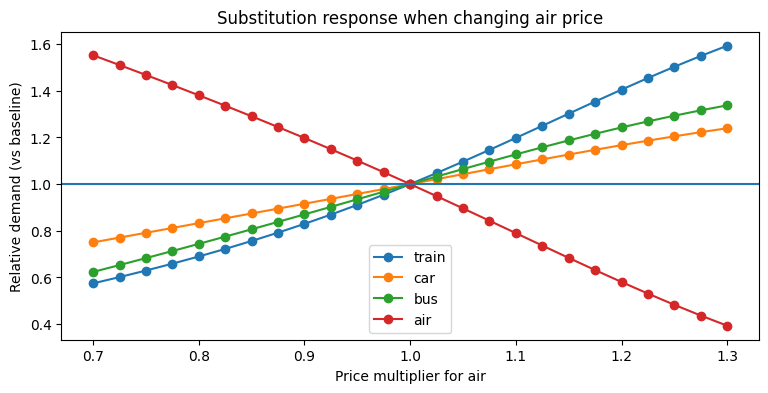

In [10]:
plot_substitution_relative(curve_df, changed_mode=changed_mode)

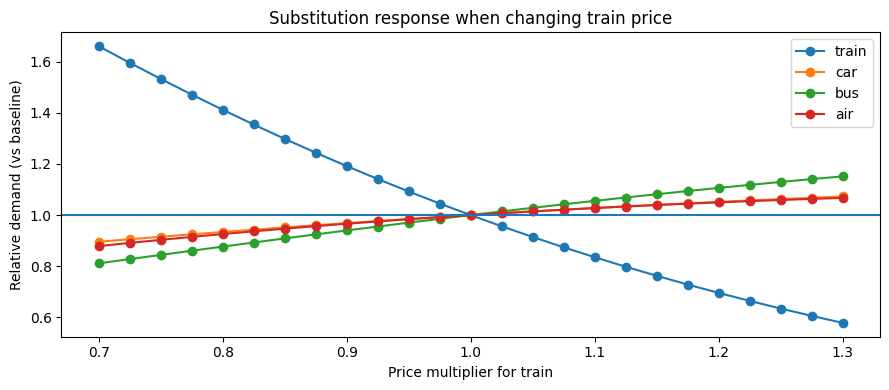

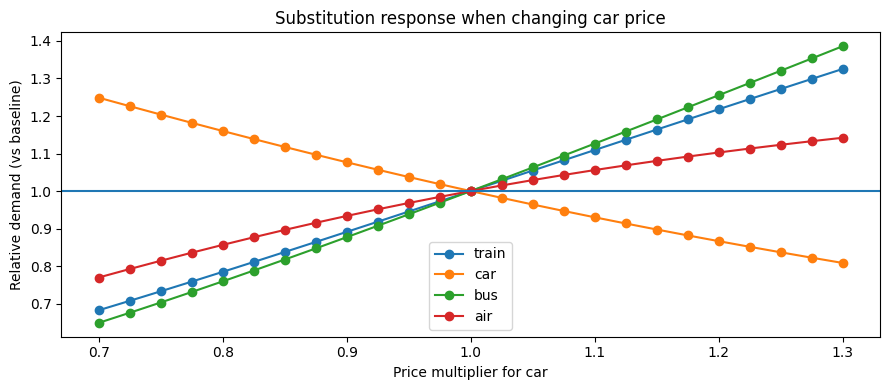

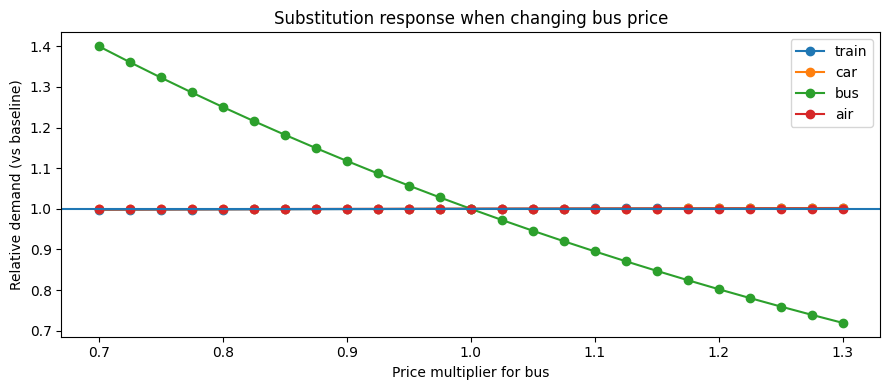

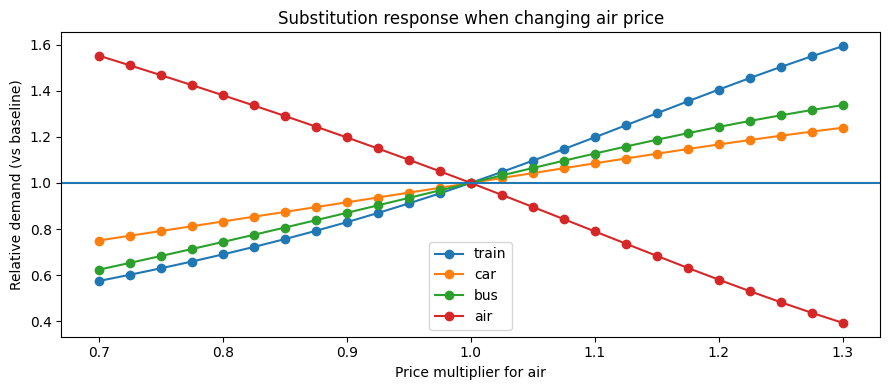

In [15]:
OUT_DIR = ROOT / "artifacts" / "substitution_plots"
OUT_DIR.mkdir(parents=True, exist_ok=True)

mult_grid = np.linspace(0.7, 1.3, 25)

for changed_mode in MODES:
    curve_df = response_curve(
        tensors=all_t,
        scaler=pipe.scaler,
        asc=asc, beta=beta, raw_la=raw_la, raw_ll=raw_ll,
        changed_mode=changed_mode,
        mult_grid=mult_grid,
    )

    # plot
    x = curve_df["multiplier"].values
    plt.figure(figsize=(9,4))
    for m in MODES:
        plt.plot(x, curve_df[f"rel_demand_{m}"].values, marker="o", label=m)
    plt.axhline(1.0)
    plt.xlabel(f"Price multiplier for {changed_mode}")
    plt.ylabel("Relative demand (vs baseline)")
    plt.title(f"Substitution response when changing {changed_mode} price")
    plt.legend()
    plt.tight_layout()

    # save
    out_path = OUT_DIR / f"substitution_{changed_mode}.png"
    plt.savefig(out_path, dpi=150)
    plt.show()

# print("Saved plots to:", OUT_DIR)

In [16]:
OUT_CSV_DIR = ROOT / "artifacts" / "substitution_tables"
OUT_CSV_DIR.mkdir(parents=True, exist_ok=True)

mult_grid = np.linspace(0.7, 1.3, 25)

for changed_mode in MODES:
    curve_df = response_curve(
        tensors=all_t,
        scaler=pipe.scaler,
        asc=asc, beta=beta, raw_la=raw_la, raw_ll=raw_ll,
        changed_mode=changed_mode,
        mult_grid=mult_grid,
    )
    curve_df.to_csv(OUT_CSV_DIR / f"curve_{changed_mode}.csv", index=False)

# print("Saved tables to:", OUT_CSV_DIR)